## 3D Layered Terzaghi Exact Solution

*Using second order central-difference method*

Note that this code takes several hours to compute a smooth 80x80x80 grid for the pore pressure contour plot. CPU cores > 64 are recommended. Using AMD EPYC 7742, solution takes 3.5 hours to complete.

In [6]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ------------------ Calculations ---------------------
poisson_ratios = [0.33, 0.35, 0.30]
youngs_moduli = [1000, 350, 3000]
permeabilities = np.array([1e-4, 2e-3, 1])*365.25 # m/day to m/year
g_w = 9.81 # specific weight of water (kN/m^3)

m_v_values = []
cv_layers = []

# Calculate m_v and cv for each layer
for v, E, k in zip(poisson_ratios, youngs_moduli, permeabilities):
    m_v = ((1 + v) * (1 - 2 * v)) / ((1 - v) * E)
    cv = k / (m_v * g_w)
    m_v_values.append(m_v)
    cv_layers.append(cv)

#Define parameters for each layer
cv_layers = [0.001, 0.9, 0.05] # soil sand layer.
layer_boundaries = [0, 1/3, 2/3, 1.0]  # Boundaries of the layers (normalized to [0,1])

N = 15
Nt = 21600
Delta_x, Delta_y, Delta_z = 1/Nx, 1/Ny, 1/Nz
Delta_t = 1/Nt  # Time step 4.63e-5 used in paper

x_range = np.linspace(0, 1, N)
y_range = np.linspace(0, 1, N) # Doubling for half plot
z_range = np.linspace(0, 1, N)
t_range = np.linspace(0, 1, Nt) # Change for t1+t2+t3 if needed

# Define the directory to save the pore pressure data
save_directory = r'C:\Users\Umar\OneDrive\UROP_PINNs\Terzaghi\Forward\Data'
os.makedirs(save_directory, exist_ok=True)

# Initial condition
u_0 = 1.0  # Initial excess pore water pressure

# Initialize pore water pressure array
u = np.zeros((len(x_range), len(y_range), len(z_range), len(t_range)))

# Apply initial condition
u[:, :, :, 0] = u_0

# Function to determine Cv based on z position
def get_cv(z):
    for i in range(len(layer_boundaries) - 1):
        if layer_boundaries[i] <= z < layer_boundaries[i + 1]:
            return cv_layers[i]
    return cv_layers[-1]  # Default to the last layer's Cv

# Start time for progress tracking
start_time = time.time()

# Time-stepping loop
for n in range(0, len(t_range) - 1):
    for i in range(1, len(x_range) - 1):
        for j in range(1, len(y_range) - 1):
            for k in range(1, len(z_range) - 1):
                cv = get_cv(z_range[k])
                u[i, j, k, n + 1] = u[i, j, k, n] + Delta_t * (
                    cv * ((u[i + 1, j, k, n] - 2 * u[i, j, k, n] + u[i - 1, j, k, n]) / Delta_x**2 +
                          (u[i, j + 1, k, n] - 2 * u[i, j, k, n] + u[i, j - 1, k, n]) / Delta_y**2 +
                          (u[i, j, k + 1, n] - 2 * u[i, j, k, n] + u[i, j, k - 1, n]) / Delta_z**2)
                )
    # Apply boundary conditions for the 3D Terzaghi problem (Case 2)
    u[0, :, :, n + 1] = 0  # u(0,y,z,t) = 0
    u[-1, :, :, n + 1] = 0  # u(l,y,z,t) = 0
    u[:, 0, :, n + 1] = 0  # u(x,0,z,t) = 0
    u[:, -1, :, n + 1] = 0  # u(x,b,z,t) = 0

    # Neumann boundary conditions for z direction (zero flux)
    u[:, :, 0, n + 1] = u[:, :, 1, n + 1]  # ∂u/∂z at z=0
    u[:, :, -1, n + 1] = u[:, :, -2, n + 1]  # ∂u/∂z at z=h

    # Continuity of pore pressure and flux at layer interfaces
    for k in range(1, len(z_range) - 1):
        if z_range[k] in layer_boundaries:
            cv_below = get_cv(z_range[k - 1])
            cv_above = get_cv(z_range[k + 1])
            u[:, :, k, n + 1] = (cv_below * u[:, :, k - 1, n + 1] + cv_above * u[:, :, k + 1, n + 1]) / (cv_below + cv_above)

    # Print progress every 2000 time steps and write to file
    if (n + 1) % 2000 == 0:
        elapsed_time = time.time() - start_time
        remaining_time = elapsed_time * (len(t_range) - n - 1) / (n + 1)
        hours, rem = divmod(remaining_time, 3600)
        minutes, seconds = divmod(rem, 60)
        progress_message = f"Time step {n + 1}/{len(t_range) - 1} completed. Estimated time remaining: {int(hours):02}:{int(minutes):02}:{int(seconds):02}"
        print(progress_message)

# Save pore pressure data to a file after completing the simulation
np.save(os.path.join(save_directory, f'3D_layered_{N}.npy'), u)
        
print("Simulation completed.")

Time step 2000/21599 completed. Estimated time remaining: 00:02:41
Time step 4000/21599 completed. Estimated time remaining: 00:02:23
Time step 6000/21599 completed. Estimated time remaining: 00:02:06
Time step 8000/21599 completed. Estimated time remaining: 00:01:50
Time step 10000/21599 completed. Estimated time remaining: 00:01:33
Time step 12000/21599 completed. Estimated time remaining: 00:01:17
Time step 14000/21599 completed. Estimated time remaining: 00:01:01
Time step 16000/21599 completed. Estimated time remaining: 00:00:45
Time step 18000/21599 completed. Estimated time remaining: 00:00:29
Time step 20000/21599 completed. Estimated time remaining: 00:00:12
Simulation completed.


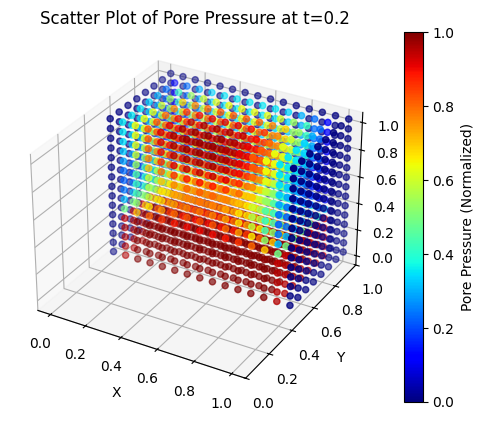

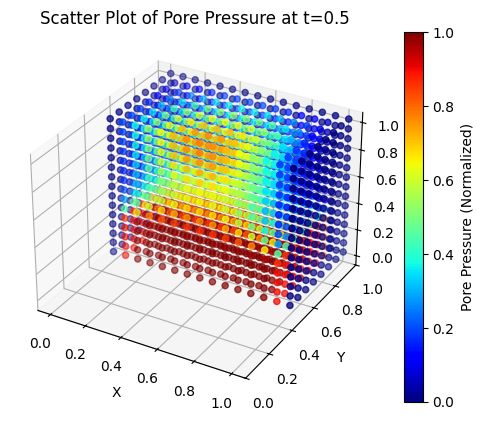

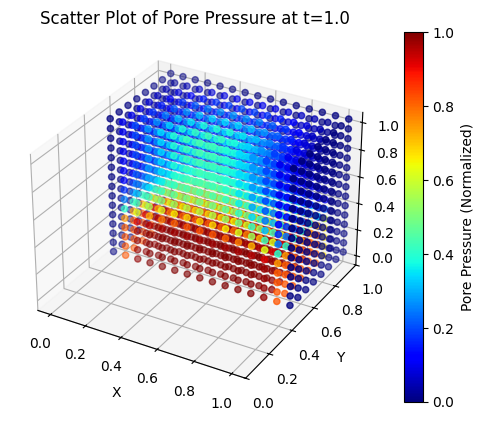

In [7]:
# Function to plot scatter plot
def plot_scatter_at_time(t_index, time_value):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Prepare the mesh grid for scatter plotting
    X, Y, Z = np.meshgrid(x_range, y_range, z_range, indexing='ij')
    
    # Extract the pore pressure at the specified time
    u_t = u[:, :, :, t_index]
    
    # Flatten the arrays for scatter plotting
    X_flat = X.flatten()
    Y_flat = Y.flatten()
    Z_flat = Z.flatten()
    u_flat = u_t.flatten()
    
    # Filter to include only the specified y range
    mask = (Y_flat >= 0.5) & (Y_flat <= 1.0)
    
    # Creating a 3D scatter plot
    scatter = ax.scatter(X_flat[mask], Y_flat[mask], Z_flat[mask], c=u_flat[mask], cmap='jet', vmin=0, vmax=1, marker='o')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Scatter Plot of Pore Pressure at t={time_value}')
    ax.set_ylim([0, 1])
    
    # Adding a color bar to indicate pressure levels
    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('Pore Pressure (Normalized)')
    plt.savefig(f'ExactSolution (t={time_value}).png', dpi=600)
    plt.show()

# Find the indices for the specific times
times = [0.2, 0.5, 1.0]
time_indices = [int(t * (Nt-1)) for t in times]

# Plot scatter plots for specified times
for t_index, time_value in zip(time_indices, times):
    plot_scatter_at_time(t_index, time_value)